## imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import pickle
import time
import matplotlib.pyplot as plt
import FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## dataset

In [3]:
# Define transformation for input data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the image data
])

In [4]:
# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [5]:
# Define data loaders
batch_size = len(train_dataset)

# Define data loaders with full batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## FNN class

In [6]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def loss_grad(self, param, inputs, labels, no_grad = False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        '''
        zeroeing gradients
        '''
        torch.nn.utils.vector_to_parameters(param, self.parameters())
        self.zero_grad(set_to_none=True)
        
        '''
        loss and grads
        '''
        outputs = model(inputs)

        if no_grad == False:
            ls = criterion(outputs, labels)
            ls.backward()
            grads = torch.cat([param.grad.data.view(-1) for param in self.parameters()], dim=0)
            return ls.item(), grads
            
        else:
            with torch.no_grad():
                ls = criterion(outputs, labels)
                return ls.item()

## create model and loss criteria

In [7]:
model = FNN().to(device)
start = torch.nn.utils.parameters_to_vector(model.parameters())
criterion = nn.CrossEntropyLoss()


In [8]:
optimizer = FINDER_core.FINDER(model)

## training loop

In [9]:
len(start)

575050

In [10]:
tic = time.time()
fX_mnist_FINDER = []
for epoch in range(100):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    total = 0.0    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        min_fitness = optimizer.step(inputs, labels)

        running_loss += min_fitness * inputs.size(0)
    running_loss /= len(train_dataset)
    fX_mnist_FINDER.append(running_loss)
    print('Epoch [%d] loss: %.6f' %
          (epoch + 1, running_loss))
toc = time.time()
print("finished training in", toc - tic, "seconds")

Epoch [1] loss: 2.273274
Epoch [2] loss: 2.211229
Epoch [3] loss: 1.807832
Epoch [4] loss: 1.602540
Epoch [5] loss: 1.410159
Epoch [6] loss: 1.397610
Epoch [7] loss: 0.844113
Epoch [8] loss: 0.836775
Epoch [9] loss: 0.820736
Epoch [10] loss: 0.749528
Epoch [11] loss: 0.735693
Epoch [12] loss: 0.708276
Epoch [13] loss: 0.630017
Epoch [14] loss: 0.622146
Epoch [15] loss: 0.589133
Epoch [16] loss: 0.572277
Epoch [17] loss: 0.554945
Epoch [18] loss: 0.548975
Epoch [19] loss: 0.542607
Epoch [20] loss: 0.472938
Epoch [21] loss: 0.464438
Epoch [22] loss: 0.455697
Epoch [23] loss: 0.437523
Epoch [24] loss: 0.421712
Epoch [25] loss: 0.411343
Epoch [26] loss: 0.386193
Epoch [27] loss: 0.377867
Epoch [28] loss: 0.370148
Epoch [29] loss: 0.348868
Epoch [30] loss: 0.337197
Epoch [31] loss: 0.320886
Epoch [32] loss: 0.311563
Epoch [33] loss: 0.302540
Epoch [34] loss: 0.280505
Epoch [35] loss: 0.274636
Epoch [36] loss: 0.253208
Epoch [37] loss: 0.249024
Epoch [38] loss: 0.243716
Epoch [39] loss: 0.22

## testing accuracy

In [11]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {correct / total * 100} %")

Accuracy on test set: 97.91 %


In [12]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on train set: {correct / total * 100} %")

Accuracy on train set: 99.89833333333334 %


In [13]:
torch.save(fX_mnist_FINDER, 'mnist_optim_fx_N575050_fullbatch.pt')

# adam

In [14]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model_adam = FNN().to(device)
torch.nn.utils.vector_to_parameters(start, model_adam.parameters()) #to set same starting point for Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_adam.parameters(), lr=0.001)
fX_adam_mnist = []
# Train the model
num_epochs = 100
tic = time.time()
for epoch in range(num_epochs):
    model_adam.train()  # Set the model to train mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model_adam(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_loss += loss.item() * inputs.size(0)
    print('Epoch [%d] loss: %.6f' %
      (epoch + 1, running_loss/len(train_dataset)))

    fX_adam_mnist.append(running_loss/ len(train_dataset))
toc = time.time()
print("\nfinished training with Adam in ",toc-tic," seconds\n")
# Test the model
model_adam.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_adam(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {correct / total * 100}")

model_adam.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_adam(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on train set: {correct / total*100}")

Epoch [1] loss: 2.309211
Epoch [2] loss: 2.283740
Epoch [3] loss: 2.250462
Epoch [4] loss: 2.198483
Epoch [5] loss: 2.119750
Epoch [6] loss: 2.009960
Epoch [7] loss: 1.871532
Epoch [8] loss: 1.711447
Epoch [9] loss: 1.531711
Epoch [10] loss: 1.341251
Epoch [11] loss: 1.151588
Epoch [12] loss: 0.978668
Epoch [13] loss: 0.854525
Epoch [14] loss: 0.839317
Epoch [15] loss: 0.779157
Epoch [16] loss: 0.707325
Epoch [17] loss: 0.650895
Epoch [18] loss: 0.629215
Epoch [19] loss: 0.573686
Epoch [20] loss: 0.581501
Epoch [21] loss: 0.531450
Epoch [22] loss: 0.520111
Epoch [23] loss: 0.503338
Epoch [24] loss: 0.481905
Epoch [25] loss: 0.469859
Epoch [26] loss: 0.455392
Epoch [27] loss: 0.445272
Epoch [28] loss: 0.423514
Epoch [29] loss: 0.421549
Epoch [30] loss: 0.411802
Epoch [31] loss: 0.391042
Epoch [32] loss: 0.388431
Epoch [33] loss: 0.383061
Epoch [34] loss: 0.367062
Epoch [35] loss: 0.362396
Epoch [36] loss: 0.356672
Epoch [37] loss: 0.346328
Epoch [38] loss: 0.342031
Epoch [39] loss: 0.33

In [15]:
torch.save(fX_adam_mnist, 'mnist_adam_fx_N575050_fullbatch.pt')

# plotting

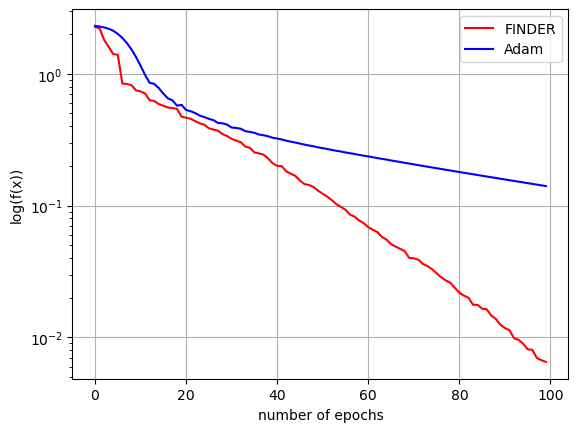

In [16]:
import matplotlib.pyplot as plt
plt.plot(fX_mnist_FINDER,'r', label = 'FINDER')
plt.plot(fX_adam_mnist,'b', label='Adam')
plt.xlabel('number of epochs')
plt.ylabel('log(f(x))')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()